In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from sklearn import gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from deeponet import *
from util import *

In [11]:
def newplot(loader,model,name):
    fig = plt.figure(figsize=(8,3.5),dpi=150)
    ax1 = fig.add_subplot(121)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    ax2 = fig.add_subplot(122)
    plt.xlabel('$x$')
    plt.ylabel('$u-u_p$')
    with torch.no_grad():
        for x, l, y in loader:
            x, l, y = x.cuda(), l.cuda(), y.cuda()
            out = model(x,l).view(-1)
            gt = y.view(-1)
            resi = out-gt
            ax1.plot(np.linspace(0,1,out.shape[-1]),out.cpu(),c='b')
            ax1.plot(np.linspace(0,1,out.shape[-1]),gt.cpu(),c='y')
            ax2.plot(np.linspace(0,1,out.shape[-1]),resi.cpu(),c='tab:blue')
    ax1.grid()
    ax2.grid()
    plt.tight_layout()
    plt.show()
    fig.savefig("img/"+name+".png")
    
def testmodel(model,loader,myloss = LpLoss(size_average=False)):
    test_mse = 0
    test_l2 = 0
    with torch.no_grad():
        for x, l, y in loader:
            x, l, y = x.cuda(), l.cuda(), y.cuda()
            out = model(x,l).view(-1)
            mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
            l2 = myloss(out.view(1, -1), y.view(1, -1))
            test_mse += mse.item()
            test_l2 += l2.item()
        test_mse /= len(loader)
        test_l2 /= ntest
        print('test error: L2 =',test_l2,'MSE =',test_mse)

In [12]:
f_train = generate(length_scale=0.2,out_dim=201)
f_0 = np.zeros_like(f_train)+1
f_test_1 = generate(samples=100,length_scale=0.2,out_dim=201)
f_test_2 = generate(samples=100,length_scale=2,out_dim=201)
f_test_3 = generate(samples=100,length_scale=0.2,A=10,out_dim=201)
f_test_4 = generate(samples=100,length_scale=2,A=10,out_dim=201)
f_test = np.concatenate((f_test_1,f_test_2))
f_test = np.concatenate((f_test,f_test_3))
f_test = np.concatenate((f_test,f_test_4))
u_0 = RK4(0,f_0)
u_train = RK4(0,f_train)
u_test = RK4(0,f_test)
f_new = 1*f_train+10
u_new = 1*u_train+10*u_0
f_aug = np.concatenate((f_train,f_new))
u_aug = np.concatenate((u_train,u_new))

dim = f_train.shape[-1]
f_train = np.delete(f_train,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
f_test = np.delete(f_test,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
f_0 = np.delete(f_0,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
f_aug = np.delete(f_aug,np.linspace(1,dim-2,(dim-1)//2).astype(np.int32).tolist(),-1)
dim = (dim-1)//2+1
grid = np.linspace(0, 1, dim)

N = f_train.shape[0]
loc = np.zeros((N,1))
res = np.zeros((N,1))
for i in range(N):
    j = np.random.randint(dim)
    loc[i,0] = grid[j]
    res[i,0] = u_train[i,j]
    
f_train = torch.Tensor(f_train)
loc_train = torch.Tensor(loc)
u_train = torch.Tensor(res)    
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_train, loc_train, u_train), batch_size=100, shuffle=True)

N = f_aug.shape[0]
loc = np.zeros((N,1))
res = np.zeros((N,1))
for i in range(N):
    j = np.random.randint(dim)
    loc[i,0] = grid[j]
    res[i,0] = u_aug[i,j]

f_aug = torch.Tensor(f_aug)
loc_aug = torch.Tensor(loc)
u_aug = torch.Tensor(res)
aug_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_aug, loc_aug, u_aug), batch_size=100, shuffle=True)

dim = f_test.shape[-1]
N = f_test.shape[0]*dim
loc = np.zeros((N,1))
res = np.zeros((N,1))
f = np.zeros((N,dim))
for i in range(N):
    f[i] = f_test[i//dim]
    loc[i,0] = grid[i%dim]
    res[i,0] = u_test[i//dim,i%dim]
f_test = torch.Tensor(f)
loc = torch.Tensor(loc)
res = torch.Tensor(res)
test_1_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[:100*dim], loc[:100*dim], res[:100*dim]), batch_size=dim, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[100*dim:200*dim], loc[100*dim:200*dim], res[100*dim:200*dim]), batch_size=dim, shuffle=False)
test_3_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[200*dim:300*dim], loc[200*dim:300*dim], res[200*dim:300*dim]), batch_size=dim, shuffle=False)
test_4_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[300*dim:], loc[300*dim:], res[300*dim:]), batch_size=dim, shuffle=False)


In [13]:
ntrain = 1000
ntest = 100
naug = 2000
batch_size = 100
learning_rate = 0.001
epochs = 600
step_size = 50
gamma = 0.5

#训练
model = DeepONet(dim,1).cuda()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
for ep in range(epochs):
    model.train()
    train_mse = 0
    for x, l, y in train_loader:
        x, l, y = x.cuda(), l.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x,l)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        mse.backward()
        optimizer.step()
        train_mse += mse.item()
    scheduler.step()
    train_mse /= len(train_loader)
    print('\repoch {:d}/{:d} MSE = {:.10f}'.format(ep+1,epochs,train_mse), end='', flush=True)
    
#torch.save(model,'model/deeponet1_1')

epoch 600/600 MSE = 0.0002363797

In [14]:
#测试
testmodel(model,test_1_loader)
testmodel(model,test_2_loader)
testmodel(model,test_3_loader)
testmodel(model,test_4_loader)

test error: L2 = 0.08889194583520293 MSE = 0.0004270703866859549
test error: L2 = 0.026984869446605445 MSE = 8.403425774304196e-05
test error: L2 = 0.011498300125822425 MSE = 0.004463696784805507
test error: L2 = 0.011036606263369322 MSE = 0.004149133826140314


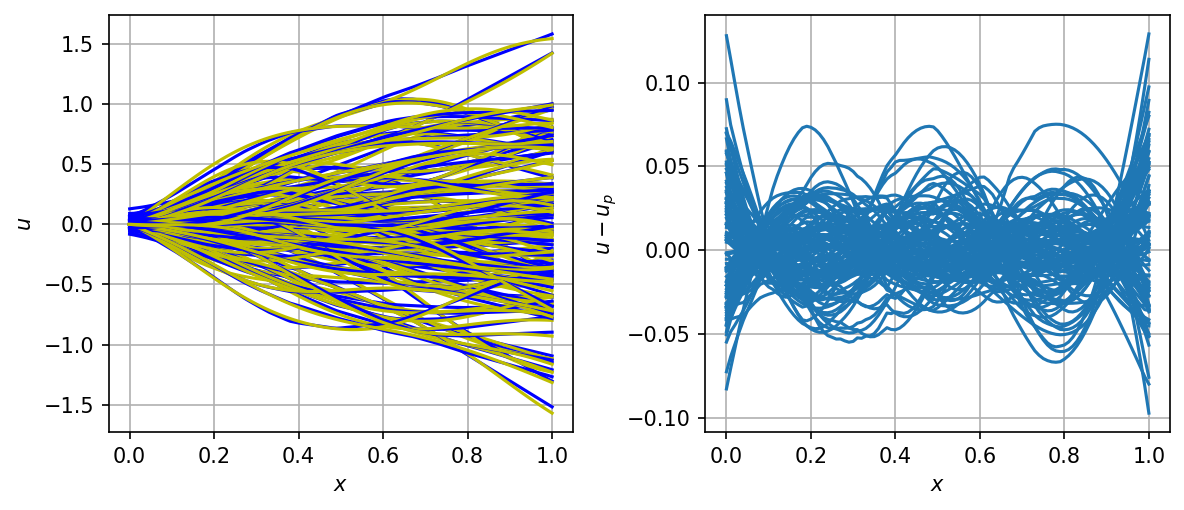

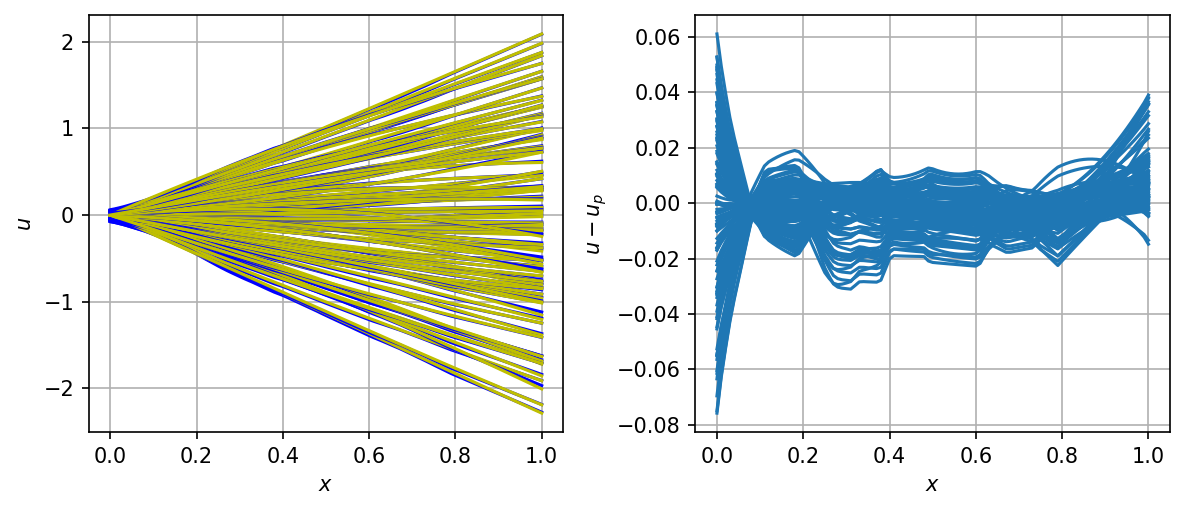

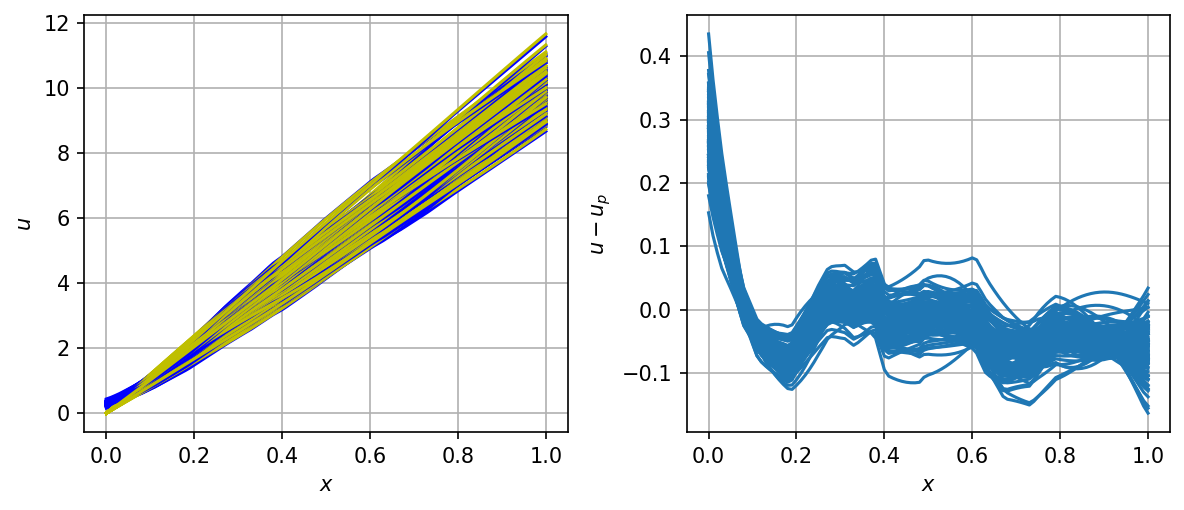

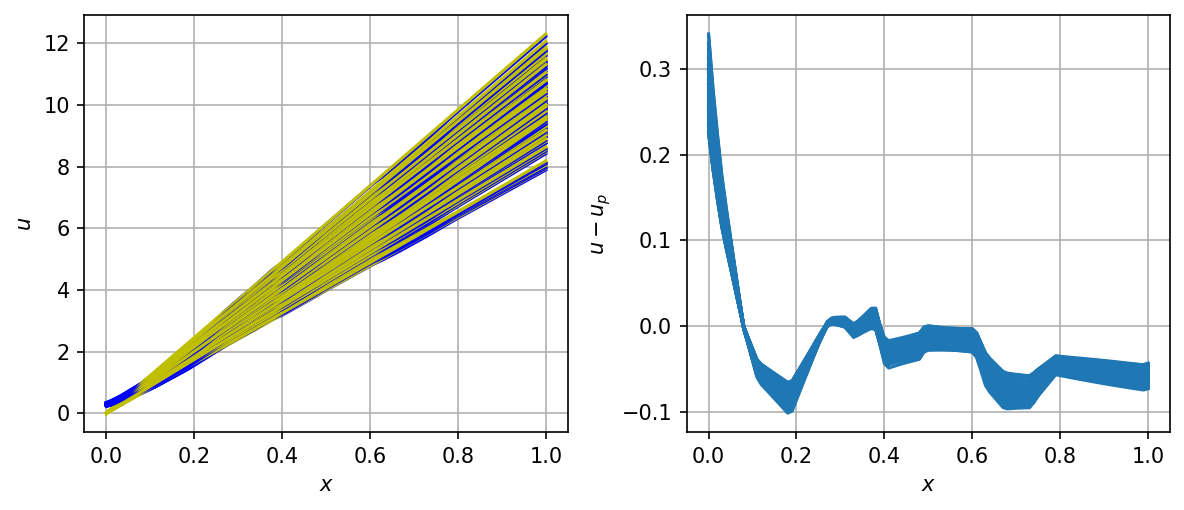

In [15]:
#画图
newplot(test_1_loader,model,'deeponet_base_1')
newplot(test_2_loader,model,'deeponet_base_2')
newplot(test_3_loader,model,'deeponet_base_3')
newplot(test_4_loader,model,'deeponet_base_4')

In [16]:
model = DeepONet(dim,1).cuda()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

for ep in range(epochs):
    model.train()
    train_mse = 0
    for x, l, y in aug_loader:
        x, l, y = x.cuda(), l.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x,l)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        mse.backward()
        optimizer.step()
        train_mse += mse.item()
    scheduler.step()
    train_mse /= len(aug_loader)
    print('\repoch {:d}/{:d} MSE = {:.10f}'.format(ep+1,epochs,train_mse), end='', flush=True)
#torch.save(model,'model/deeponet1_2')

epoch 600/600 MSE = 0.0010485002

In [17]:
testmodel(model,test_1_loader)
testmodel(model,test_2_loader)
testmodel(model,test_3_loader)
testmodel(model,test_4_loader)

test error: L2 = 0.15302353482693434 MSE = 0.0014764487973297946
test error: L2 = 0.03411960011348128 MSE = 0.00013443314511278005
test error: L2 = 0.005468447399907745 MSE = 0.0012397145198701765
test error: L2 = 0.0009145709138829261 MSE = 2.870249752959353e-05


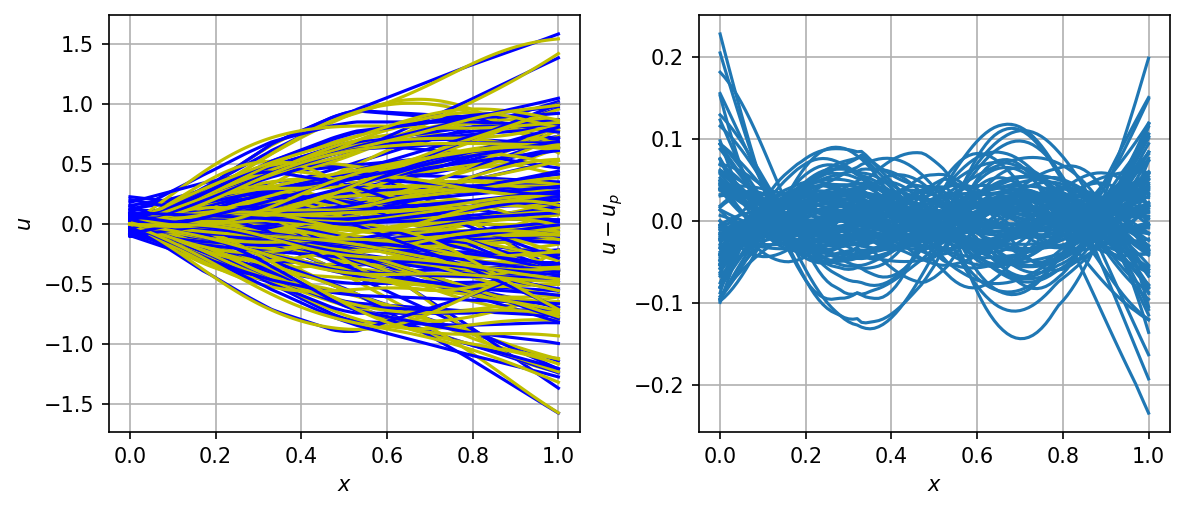

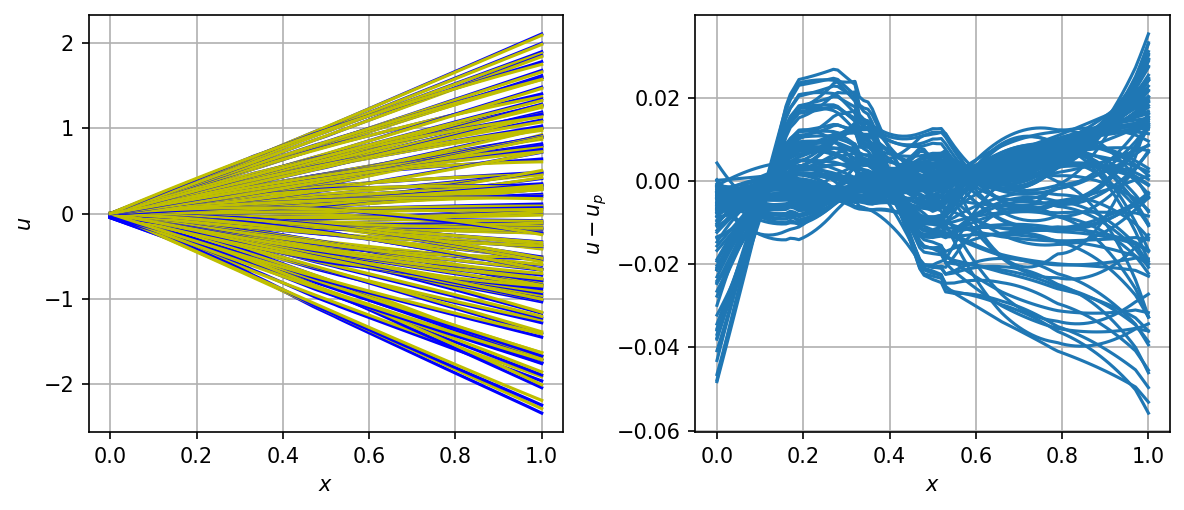

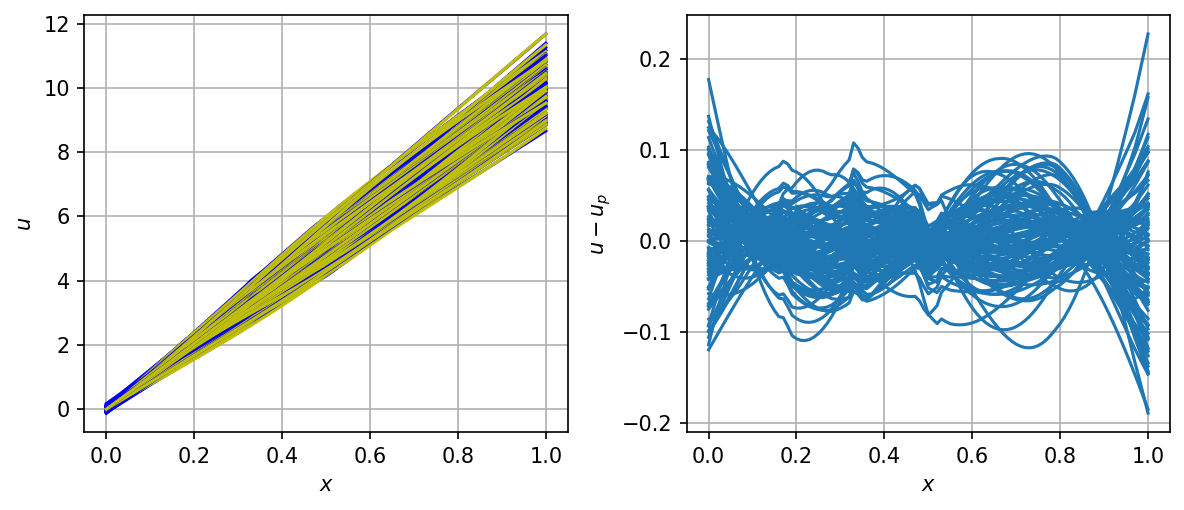

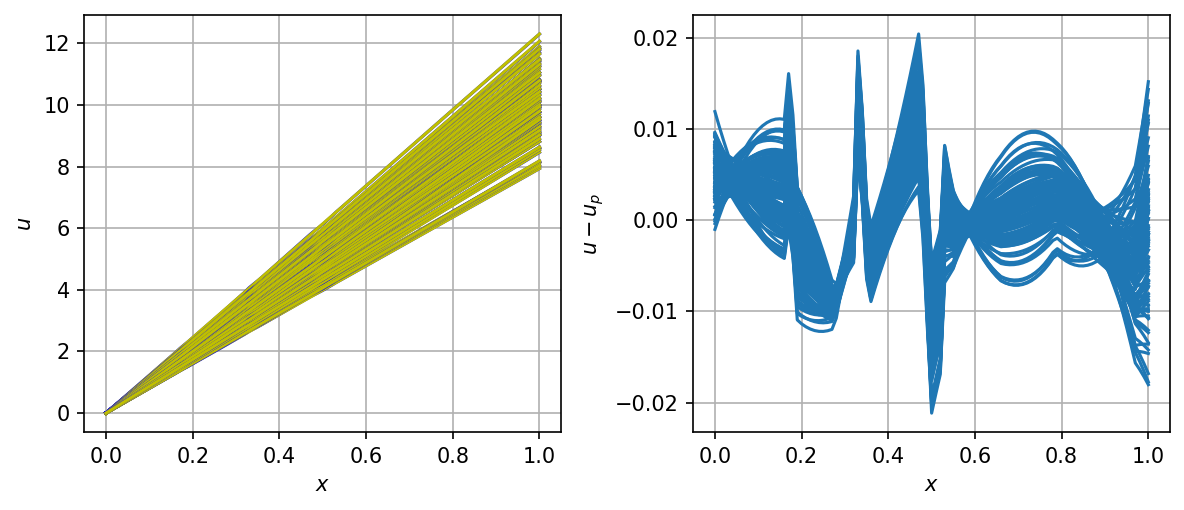

In [18]:
newplot(test_1_loader,model,'deeponet_pgda_1')
newplot(test_2_loader,model,'deeponet_pgda_2')
newplot(test_3_loader,model,'deeponet_pgda_3')
newplot(test_4_loader,model,'deeponet_pgda_4')